In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns

In [2]:
from time import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [4]:
from datetime import datetime
from datetime import timedelta


In [5]:
#defining parser for dates
def date_parser_(s):
    return str(datetime.strptime(s, '%d-%m-%Y-%H:%M:%S:%f'))

In [6]:
df=pd.read_csv('New_Data.csv',parse_dates=[0],index_col=0,date_parser=date_parser_)

FileNotFoundError: ignored

In [ ]:
df

,Solar Current
Dates,
2022-11-02 00:01:54.597,7.9338
2022-11-02 00:02:02.789,7.8104
2022-11-02 00:02:06.885,7.9338
2022-11-02 00:05:11.206,8.1806
2022-11-02 00:05:15.302,8.0572
...,...
2022-11-02 23:51:37.663,8.6742
2022-11-02 23:54:41.985,8.4274
2022-11-02 23:54:46.081,8.3040


In [ ]:
df.describe(include='all')

,Solar Current
count,1784.000000
mean,8.509367
std,2.417645
min,-7.861400
25%,6.946600
50%,7.810400
75%,9.784800
max,13.980400


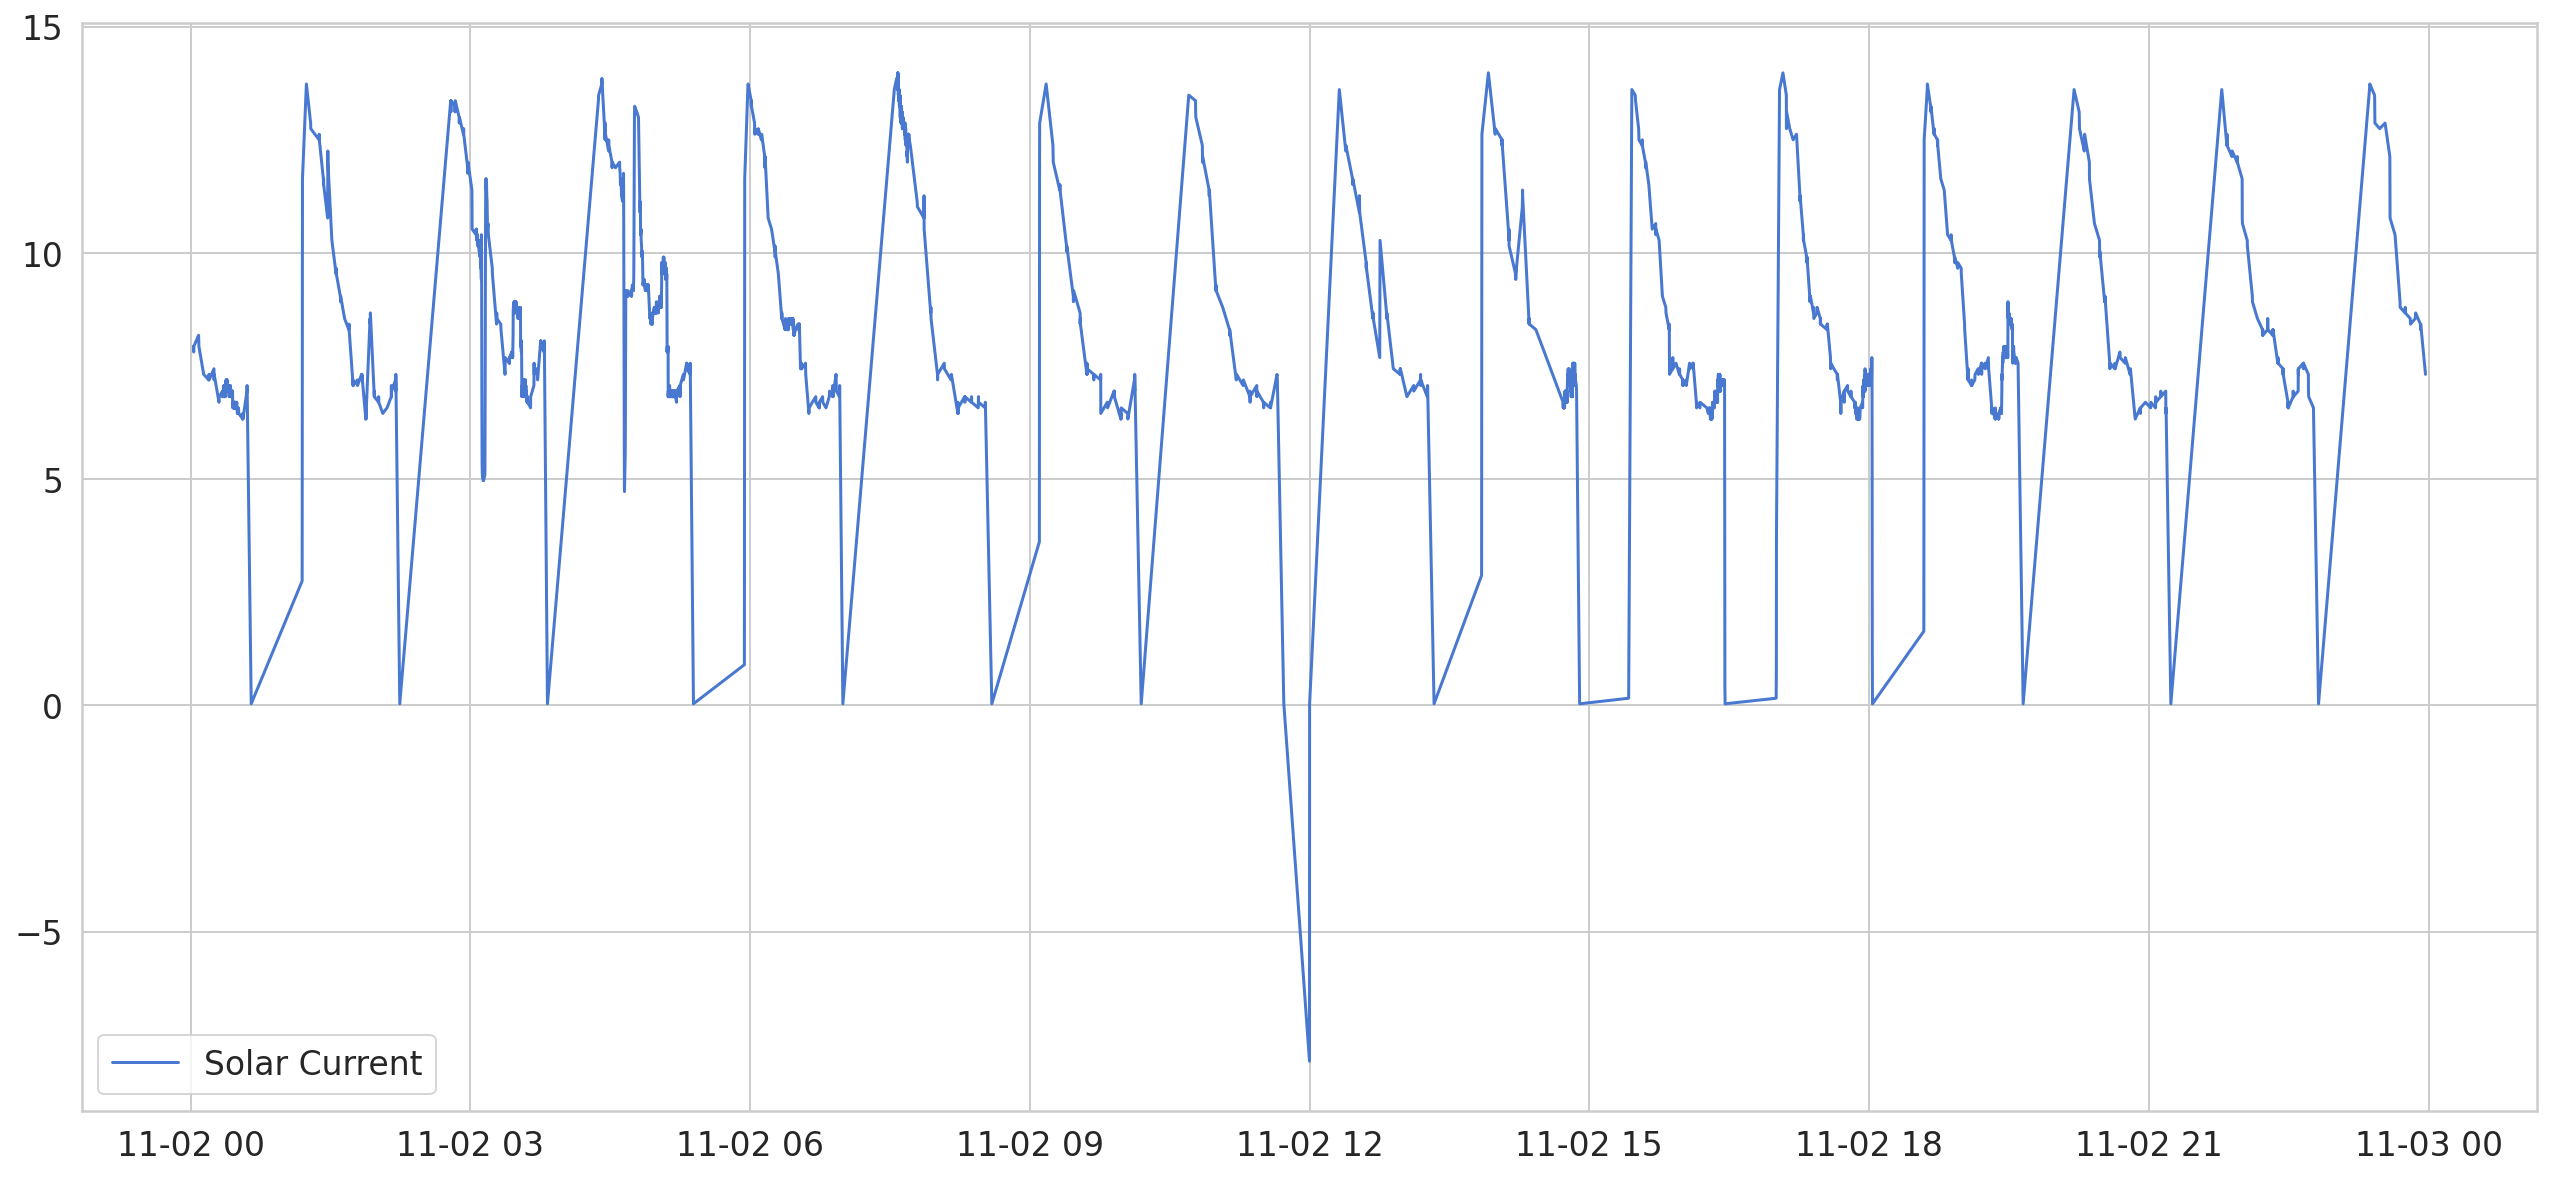

In [ ]:
plt.plot(df, label='Solar Current')
plt.legend()


In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
df.columns

Index(['Solar Current'], dtype='object')

In [ ]:
#Dickey fuller test
def stationarity_test(data):
    dftest = adfuller(data, autolag='AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\n",key, ": ", val)
    

In [ ]:
stationarity_test(df['Solar Current'])

1. ADF :  -8.957026784939886
2. P-Value :  8.42005673673431e-15
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression: 1780
5. Critical Values :

 1% :  -3.434029076071607

 5% :  -2.8631651074657185

 10% :  -2.567635156230274


In [ ]:
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)


(1248, 1) (536, 1)


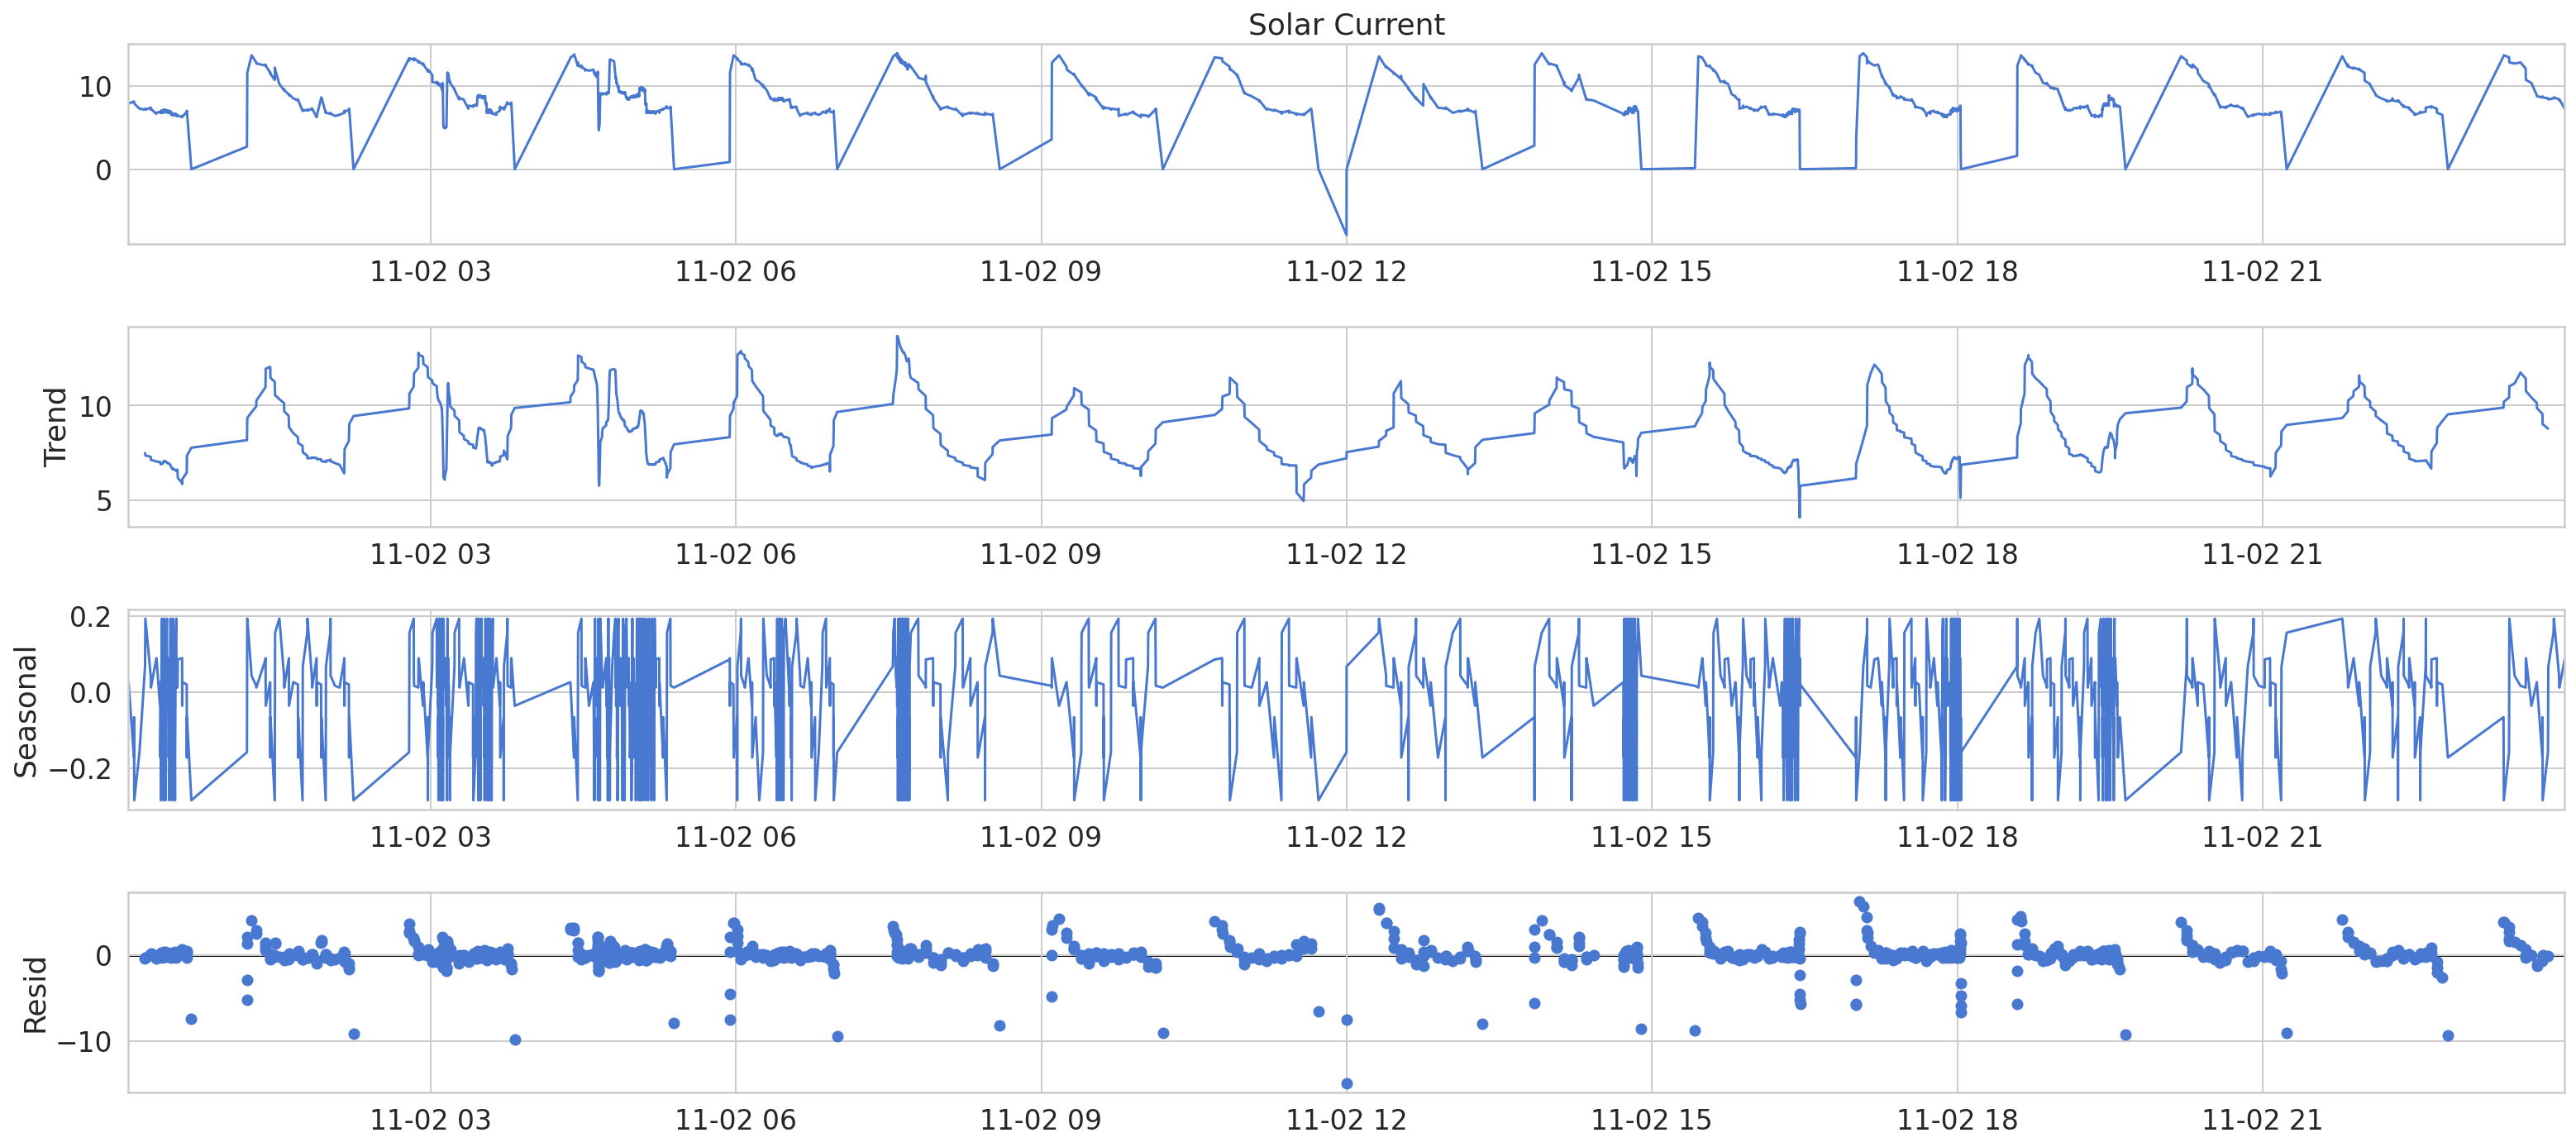

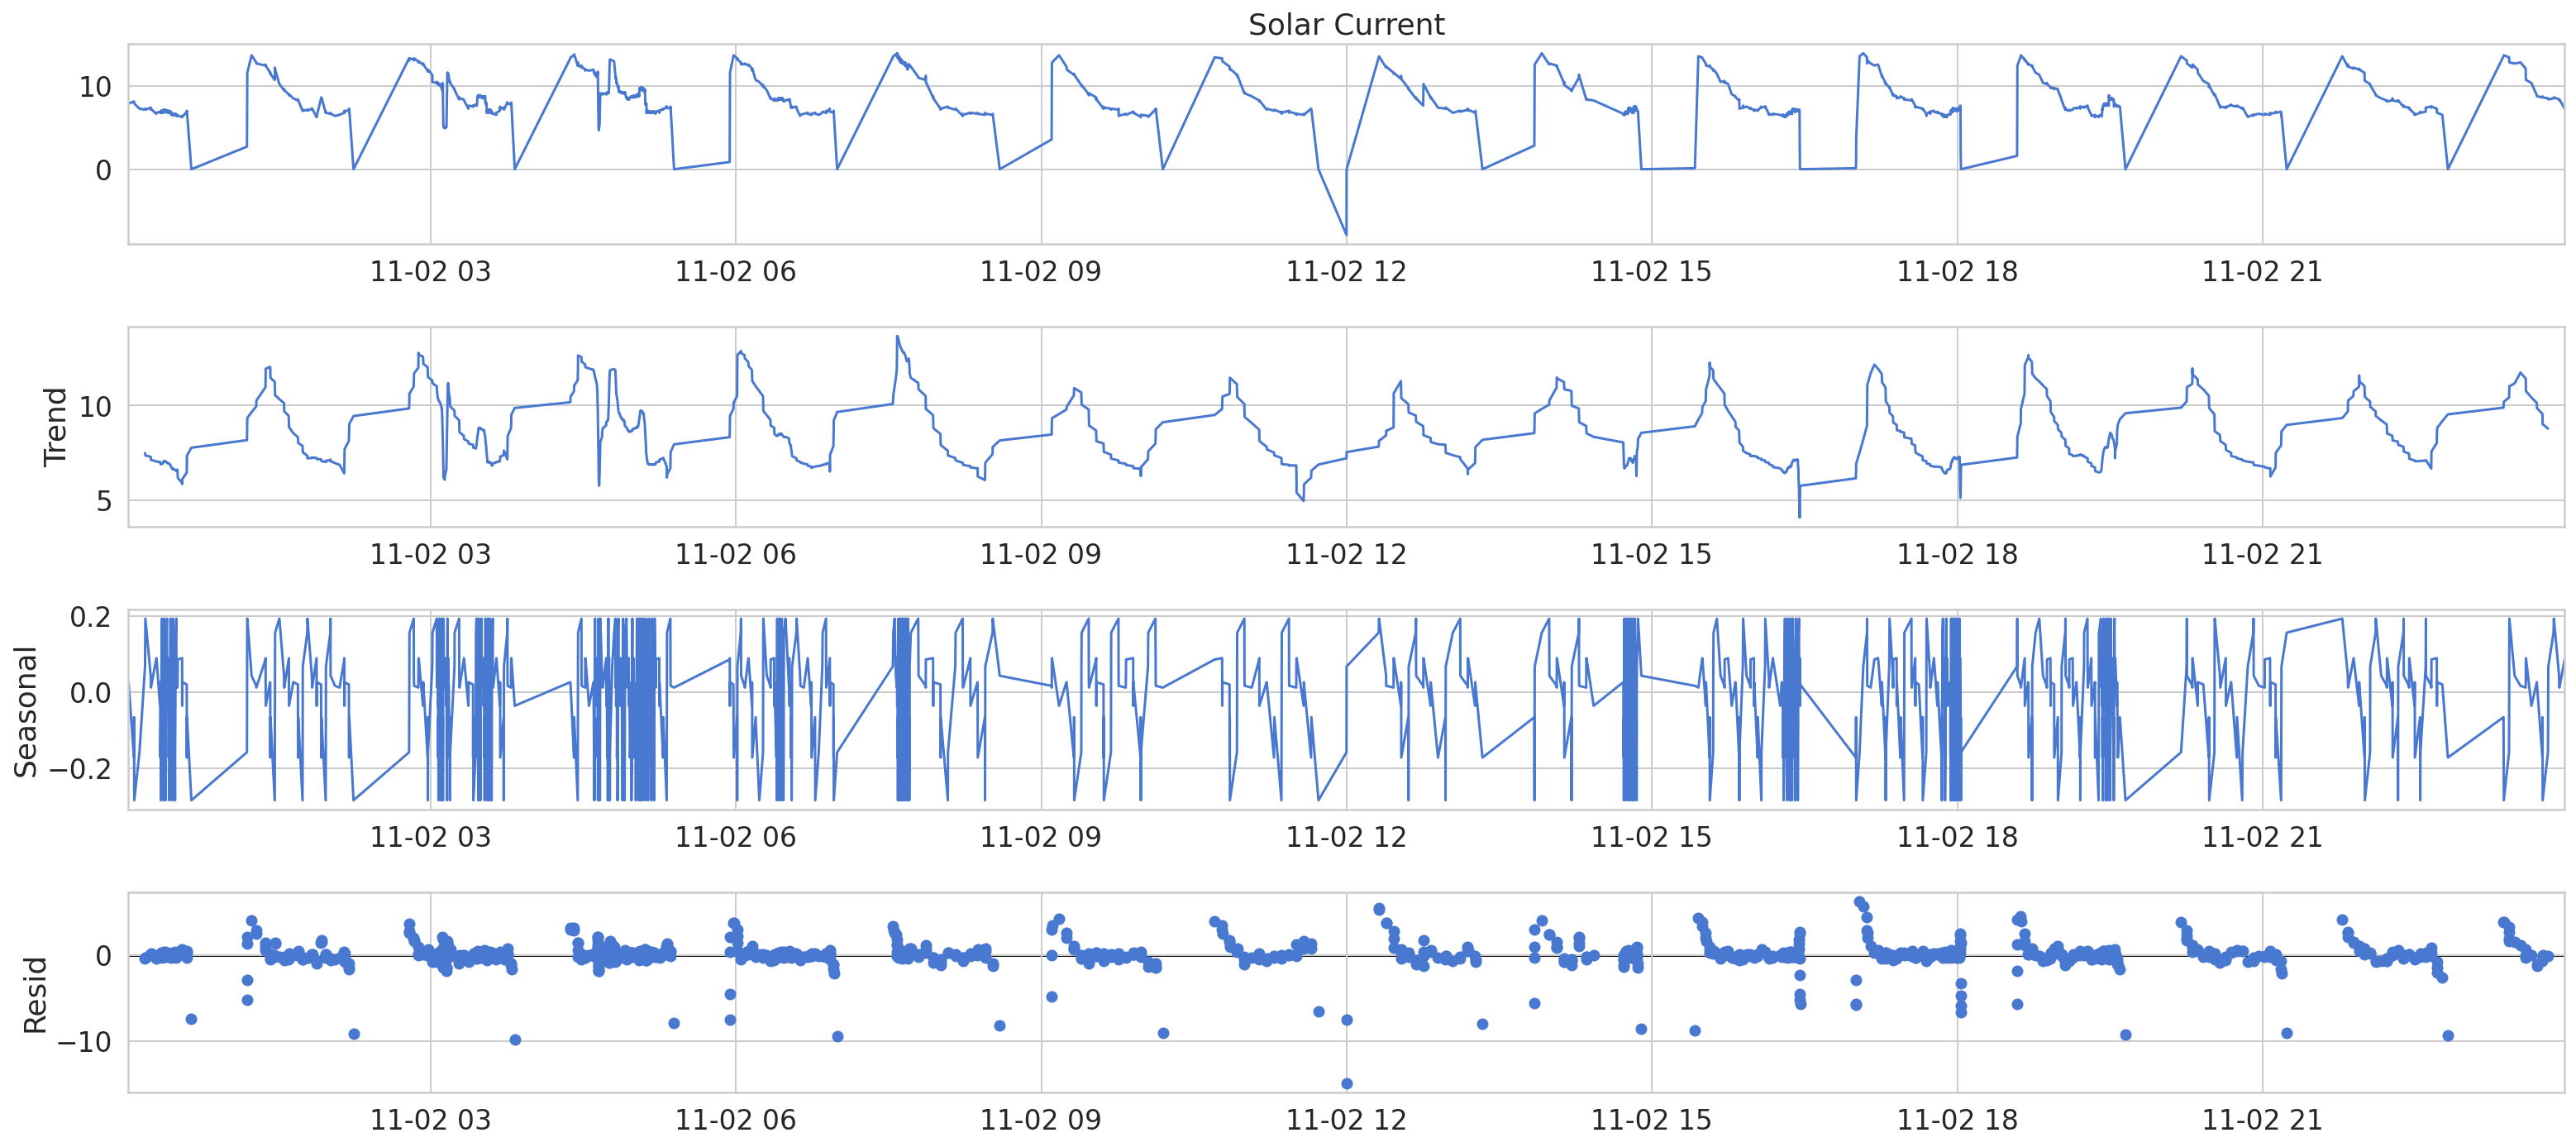

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(
    df['Solar Current'], model="additive", period=15)
decompose_data.plot()

In [ ]:
from sklearn.preprocessing import StandardScaler


In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Solar Current']])

In [ ]:
train['Solar Current'] = scaler.transform(train[['Solar Current']])
test['Solar Current'] = scaler.transform(test[['Solar Current']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#timesteps defines to look back
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [ ]:
TIME_STEPS = 50

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['Solar Current']], train['Solar Current'], TIME_STEPS)
X_test, y_test = create_dataset(test[['Solar Current']], test['Solar Current'], TIME_STEPS)

print(X_train.shape)


(1198, 50, 1)


In [ ]:
X_test.shape

(486, 50, 1)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))

In [ ]:
model.add(keras.layers.Dropout(rate=0.2))#regularisation factor
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])))

In [ ]:
model.compile(loss='mae', optimizer='adam')


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.15,
    shuffle=False
)


Epoch 1/30
32/32 [==============================] - 5s 160ms/step - loss: 0.7235 - val_loss: 0.6199
Epoch 2/30
32/32 [==============================] - 4s 131ms/step - loss: 0.5603 - val_loss: 0.5039
Epoch 3/30
32/32 [==============================] - 3s 94ms/step - loss: 0.5792 - val_loss: 0.4918
Epoch 4/30
32/32 [==============================] - 2s 68ms/step - loss: 0.5188 - val_loss: 0.4903
Epoch 5/30
32/32 [==============================] - 2s 70ms/step - loss: 0.5096 - val_loss: 0.5032
Epoch 6/30
32/32 [==============================] - 2s 69ms/step - loss: 0.5061 - val_loss: 0.5146
Epoch 7/30
32/32 [==============================] - 2s 69ms/step - loss: 0.5046 - val_loss: 0.5045
Epoch 8/30
32/32 [==============================] - 2s 76ms/step - loss: 0.5014 - val_loss: 0.5044
Epoch 9/30
32/32 [==============================] - 2s 69ms/step - loss: 0.4924 - val_loss: 0.5115
Epoch 10/30
32/32 [==============================] - 2s 66ms/step - loss: 0.4938 - val_loss: 0.5144
Epoch 1

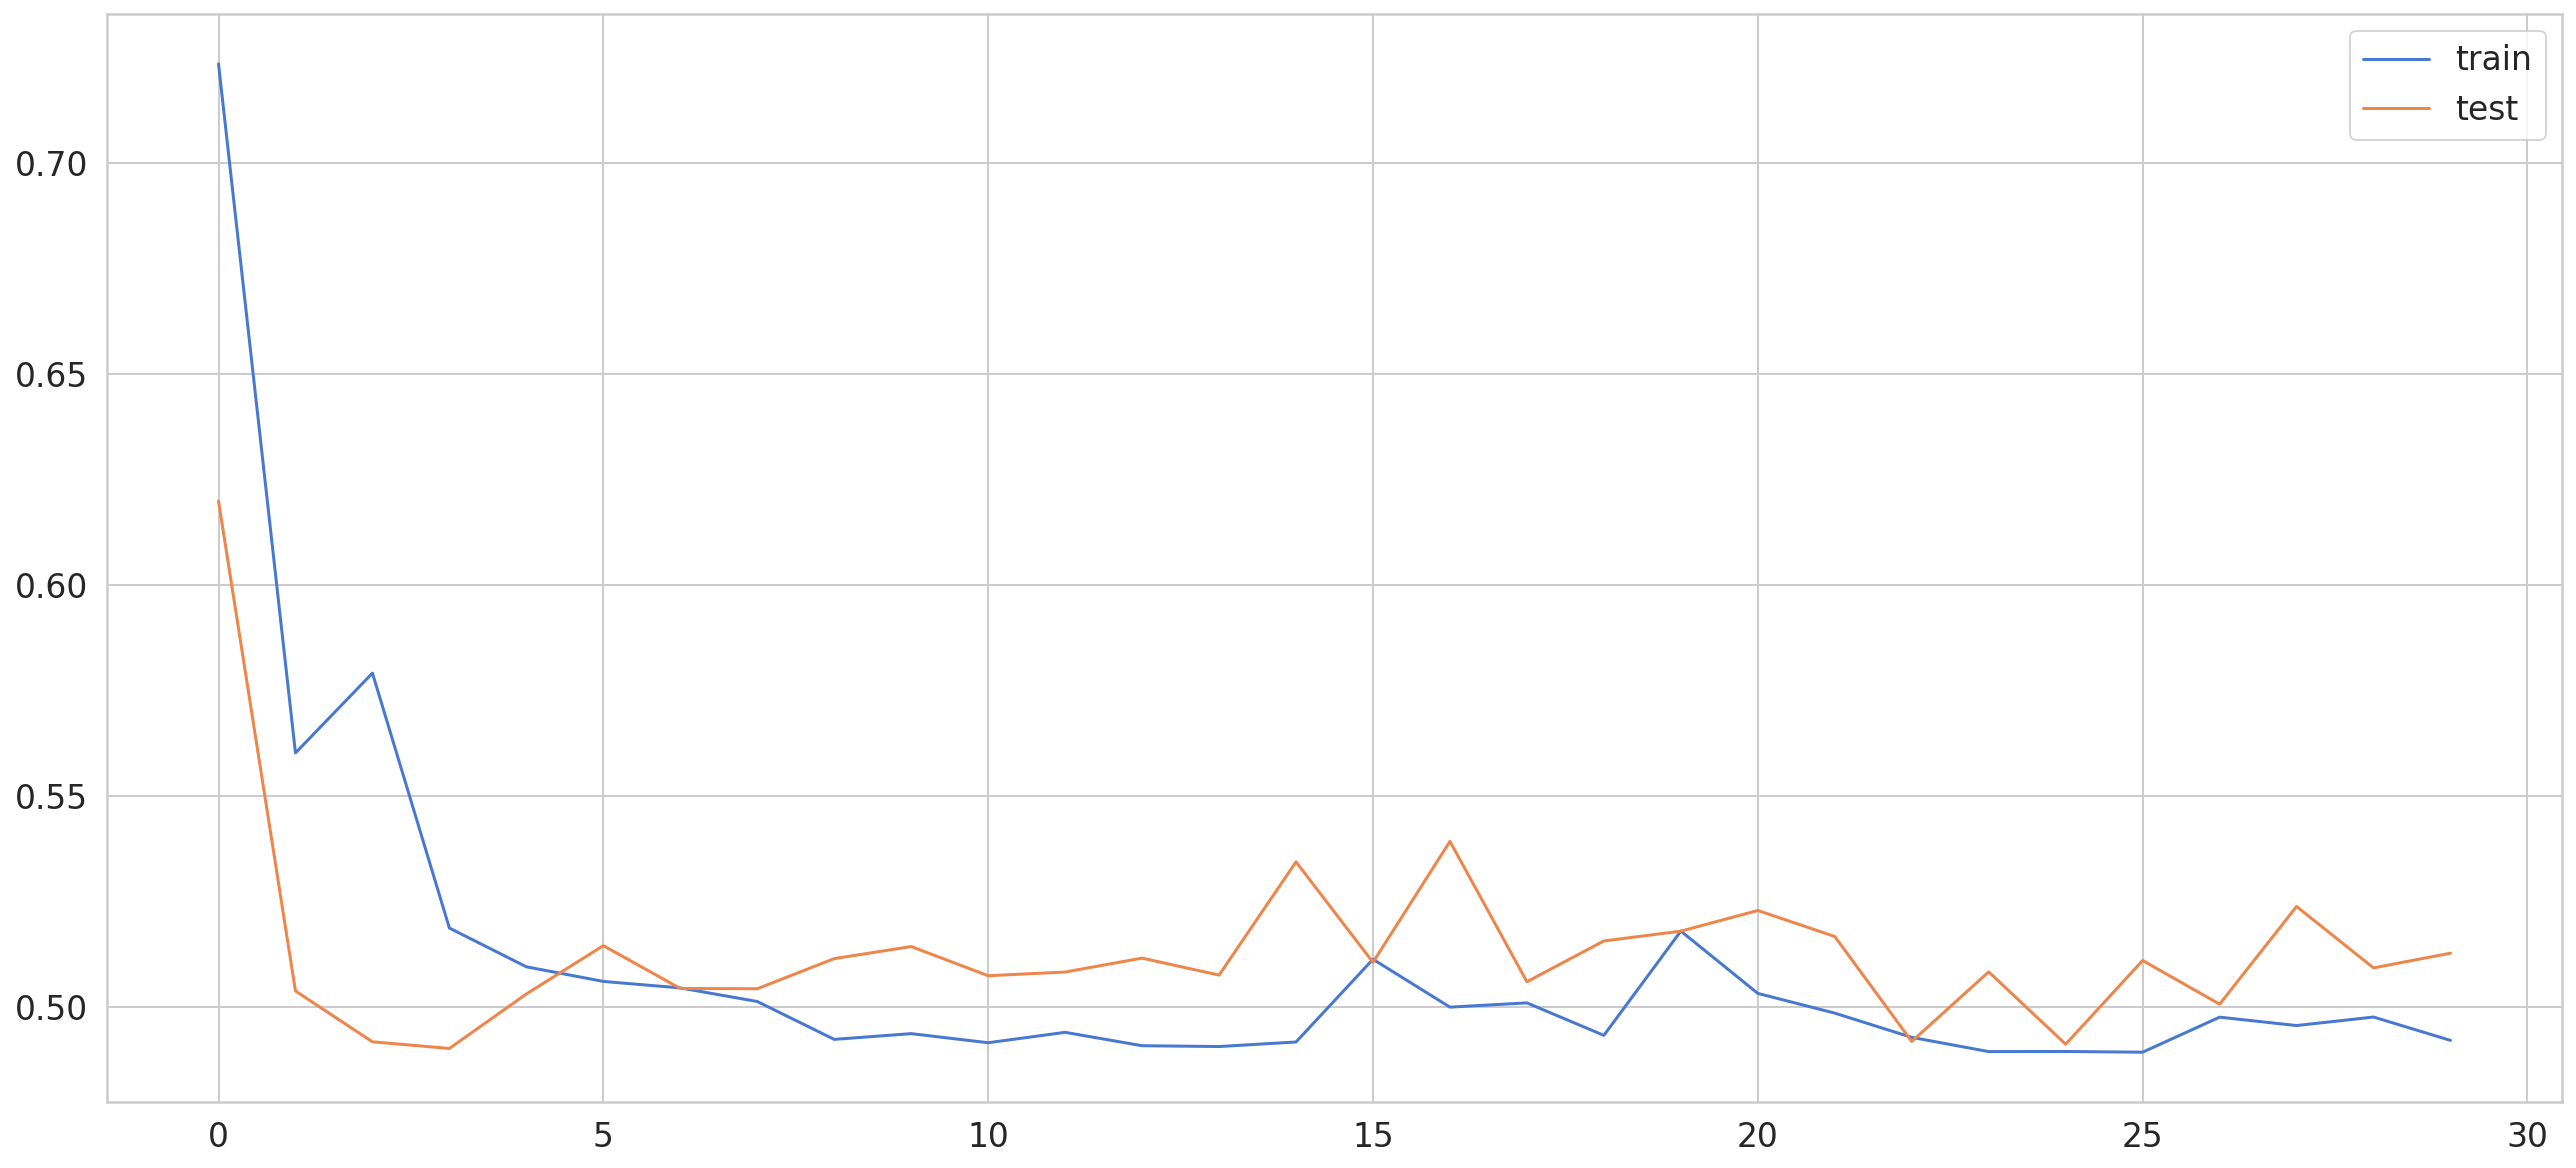

In [ ]:
#training and testing loss

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
X_train

array([[[-0.34692135],
        [-0.39723603],
        [-0.34692135],
        ...,
        [-0.64880944],
        [-0.69912412],
        [-0.74943881]],

       [[-0.39723603],
        [-0.34692135],
        [-0.24629198],
        ...,
        [-0.69912412],
        [-0.74943881],
        [-0.69912412]],

       [[-0.34692135],
        [-0.24629198],
        [-0.29660667],
        ...,
        [-0.74943881],
        [-0.69912412],
        [-0.74943881]],

       ...,

       [[-3.56706102],
        [-3.51674633],
        [ 1.96755404],
        ...,
        [-0.85006817],
        [-0.90038285],
        [-0.85006817]],

       [[-3.51674633],
        [ 1.96755404],
        [ 1.91723936],
        ...,
        [-0.90038285],
        [-0.85006817],
        [-0.90038285]],

       [[ 1.96755404],
        [ 1.91723936],
        [ 1.86692468],
        ...,
        [-0.85006817],
        [-0.90038285],
        [-0.95069754]]])

In [ ]:
X_train_pred = model.predict(X_train)

38/38 [==============================] - 1s 19ms/step


In [ ]:
#analysing through mean absolute error
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


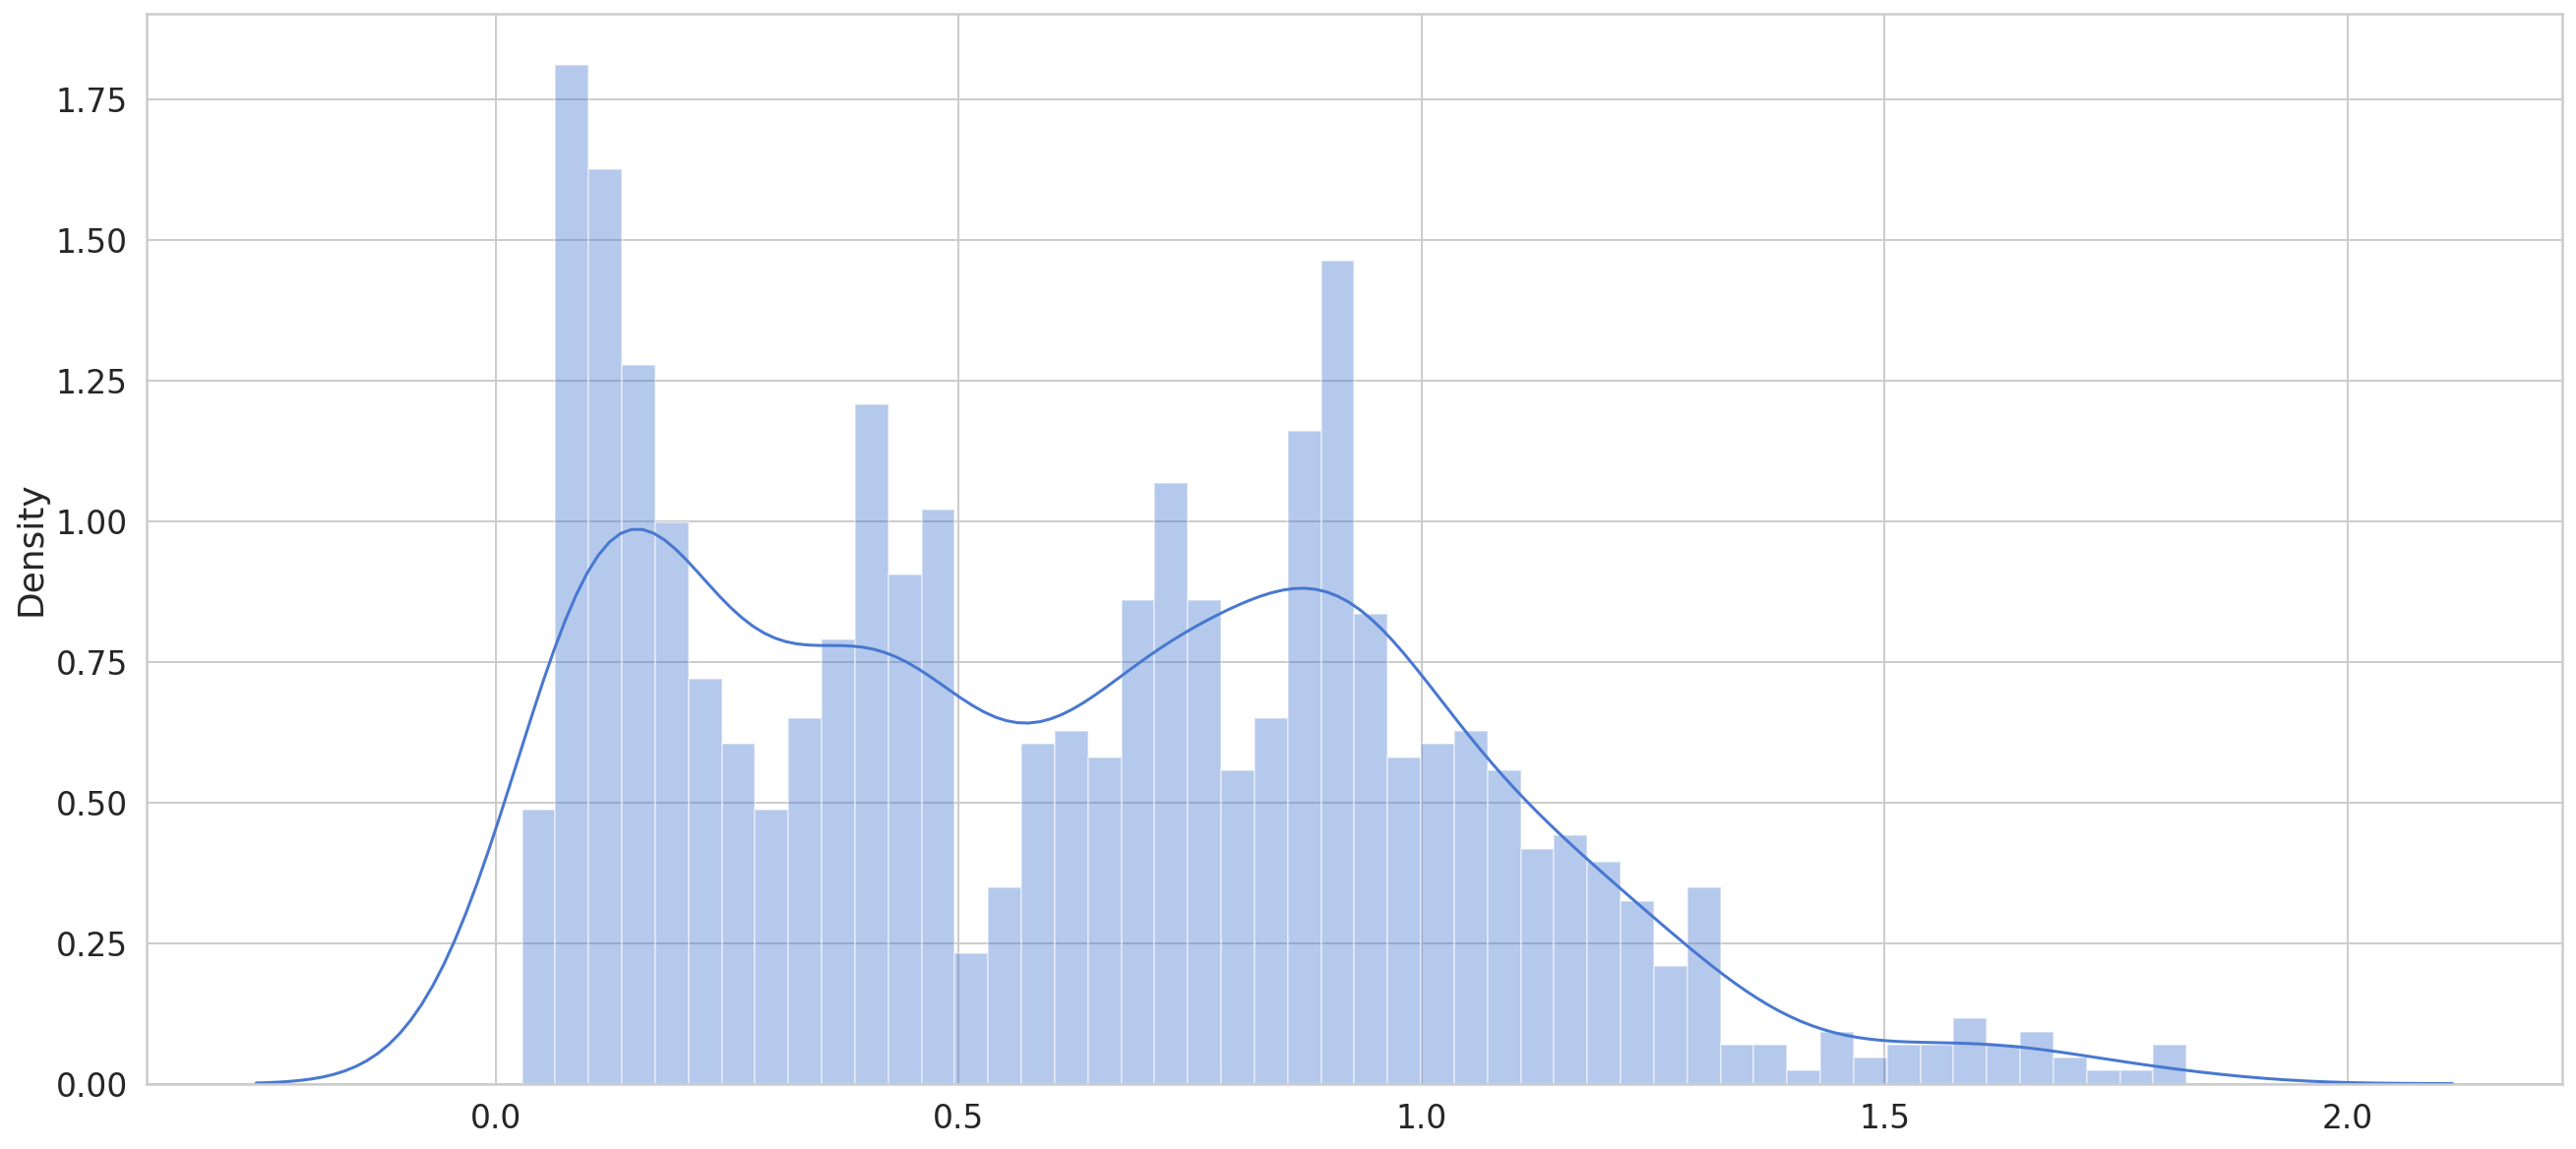

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)


In [ ]:
X_test_pred = model.predict(X_test)


16/16 [==============================] - 0s 18ms/step


In [ ]:
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


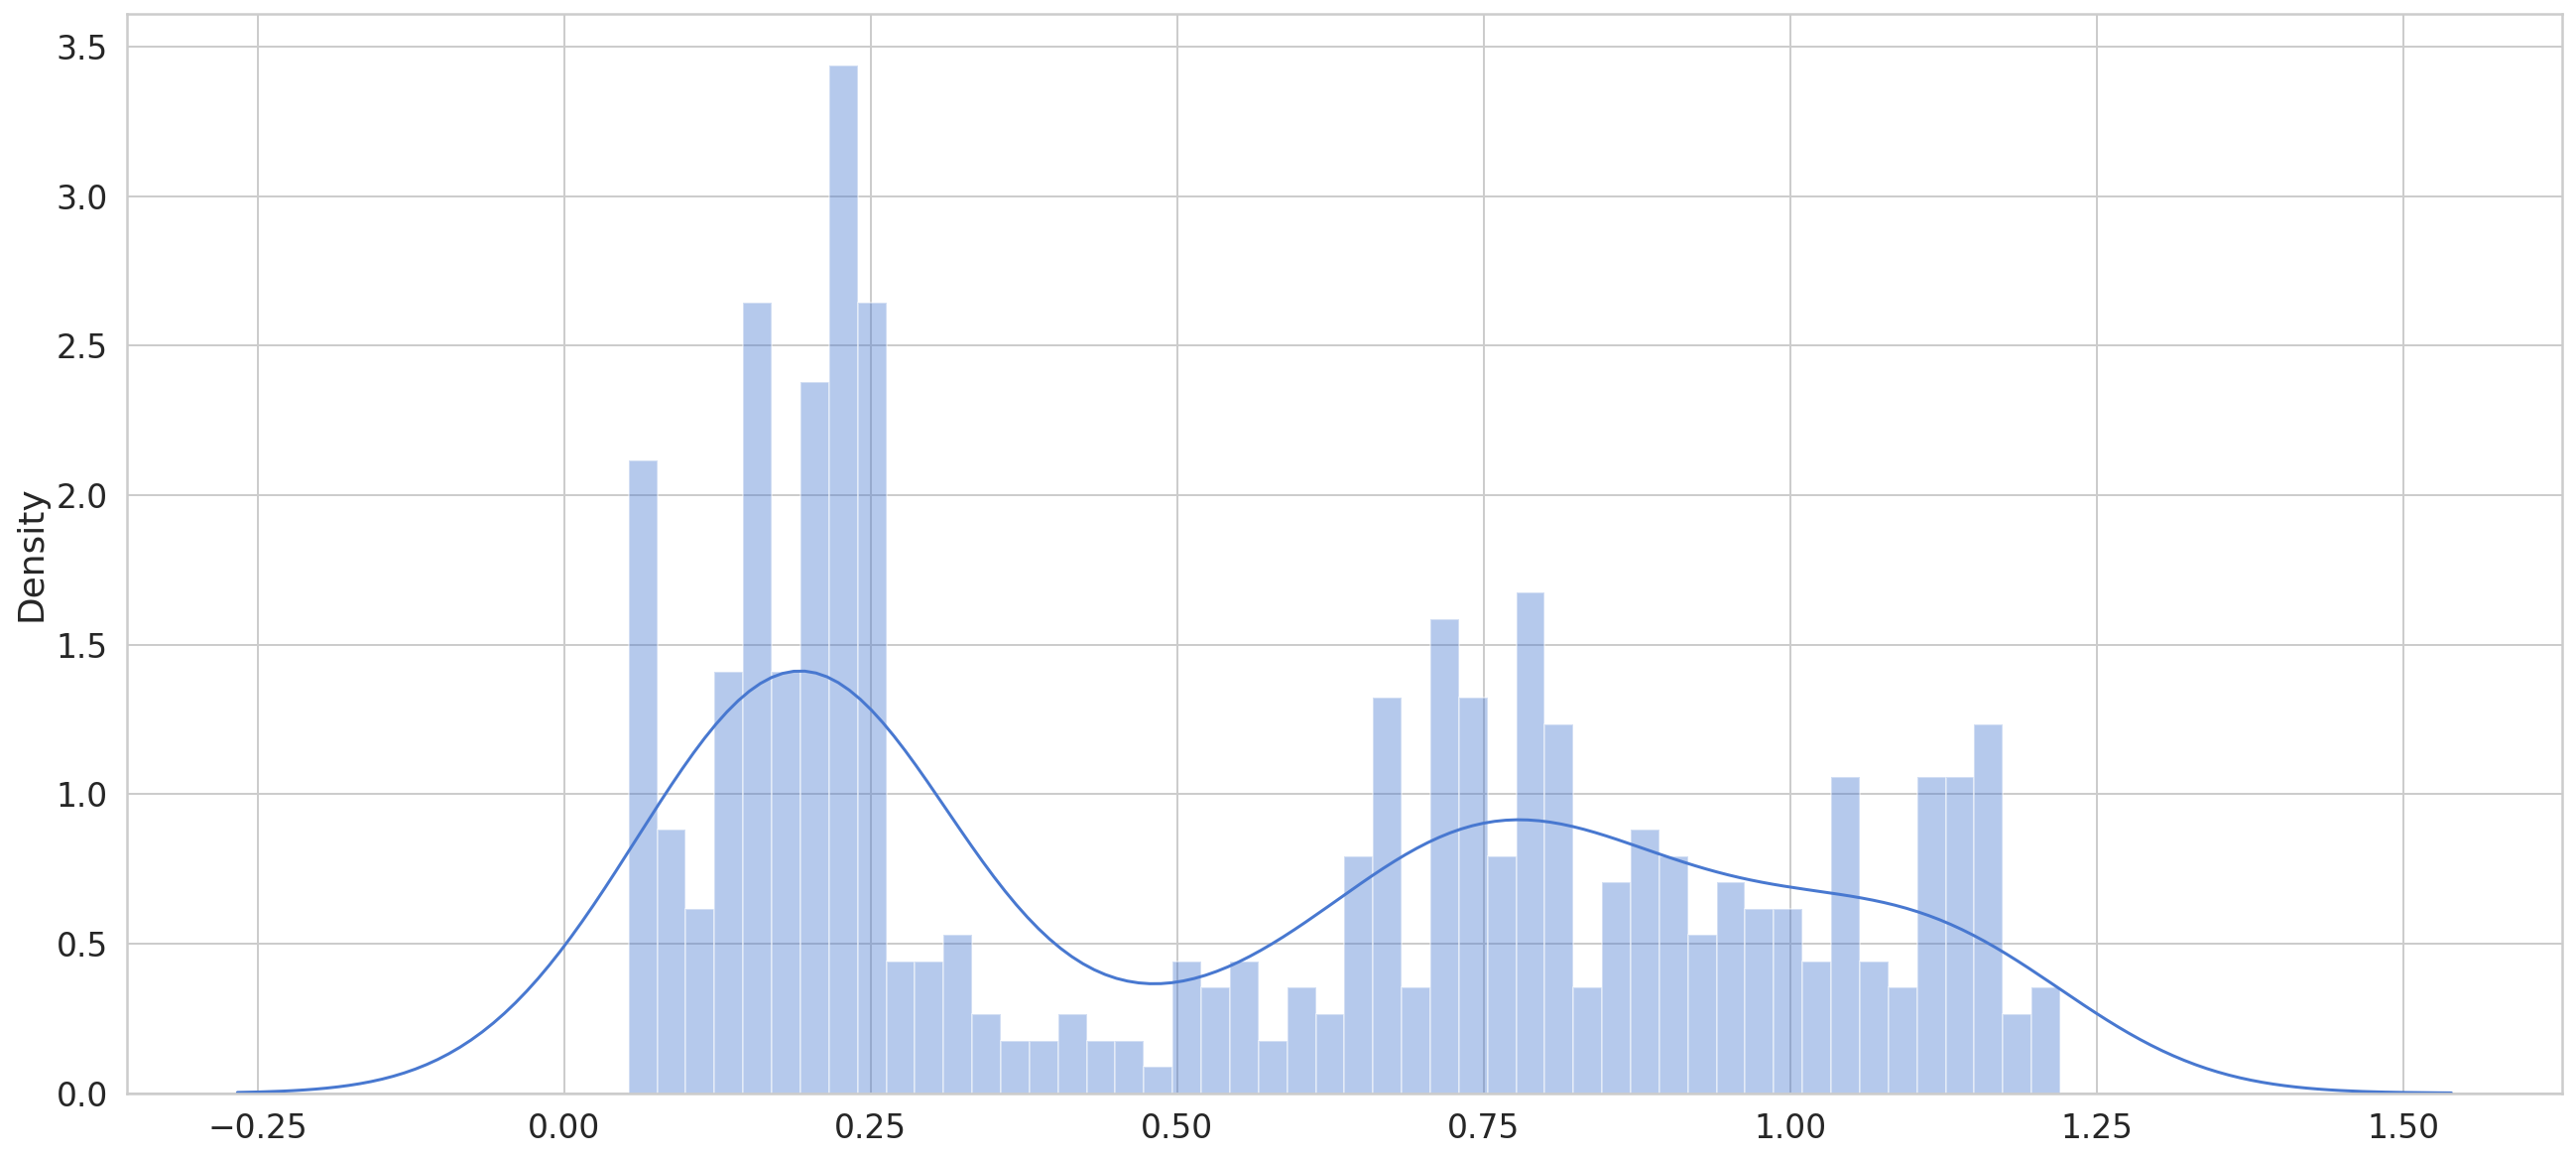

In [ ]:
sns.distplot(test_mae_loss, bins=50, kde=True)


In [ ]:
THRESHOLD = 0.8

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)


In [ ]:
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Solar_Current'] = test[TIME_STEPS:]['Solar Current']

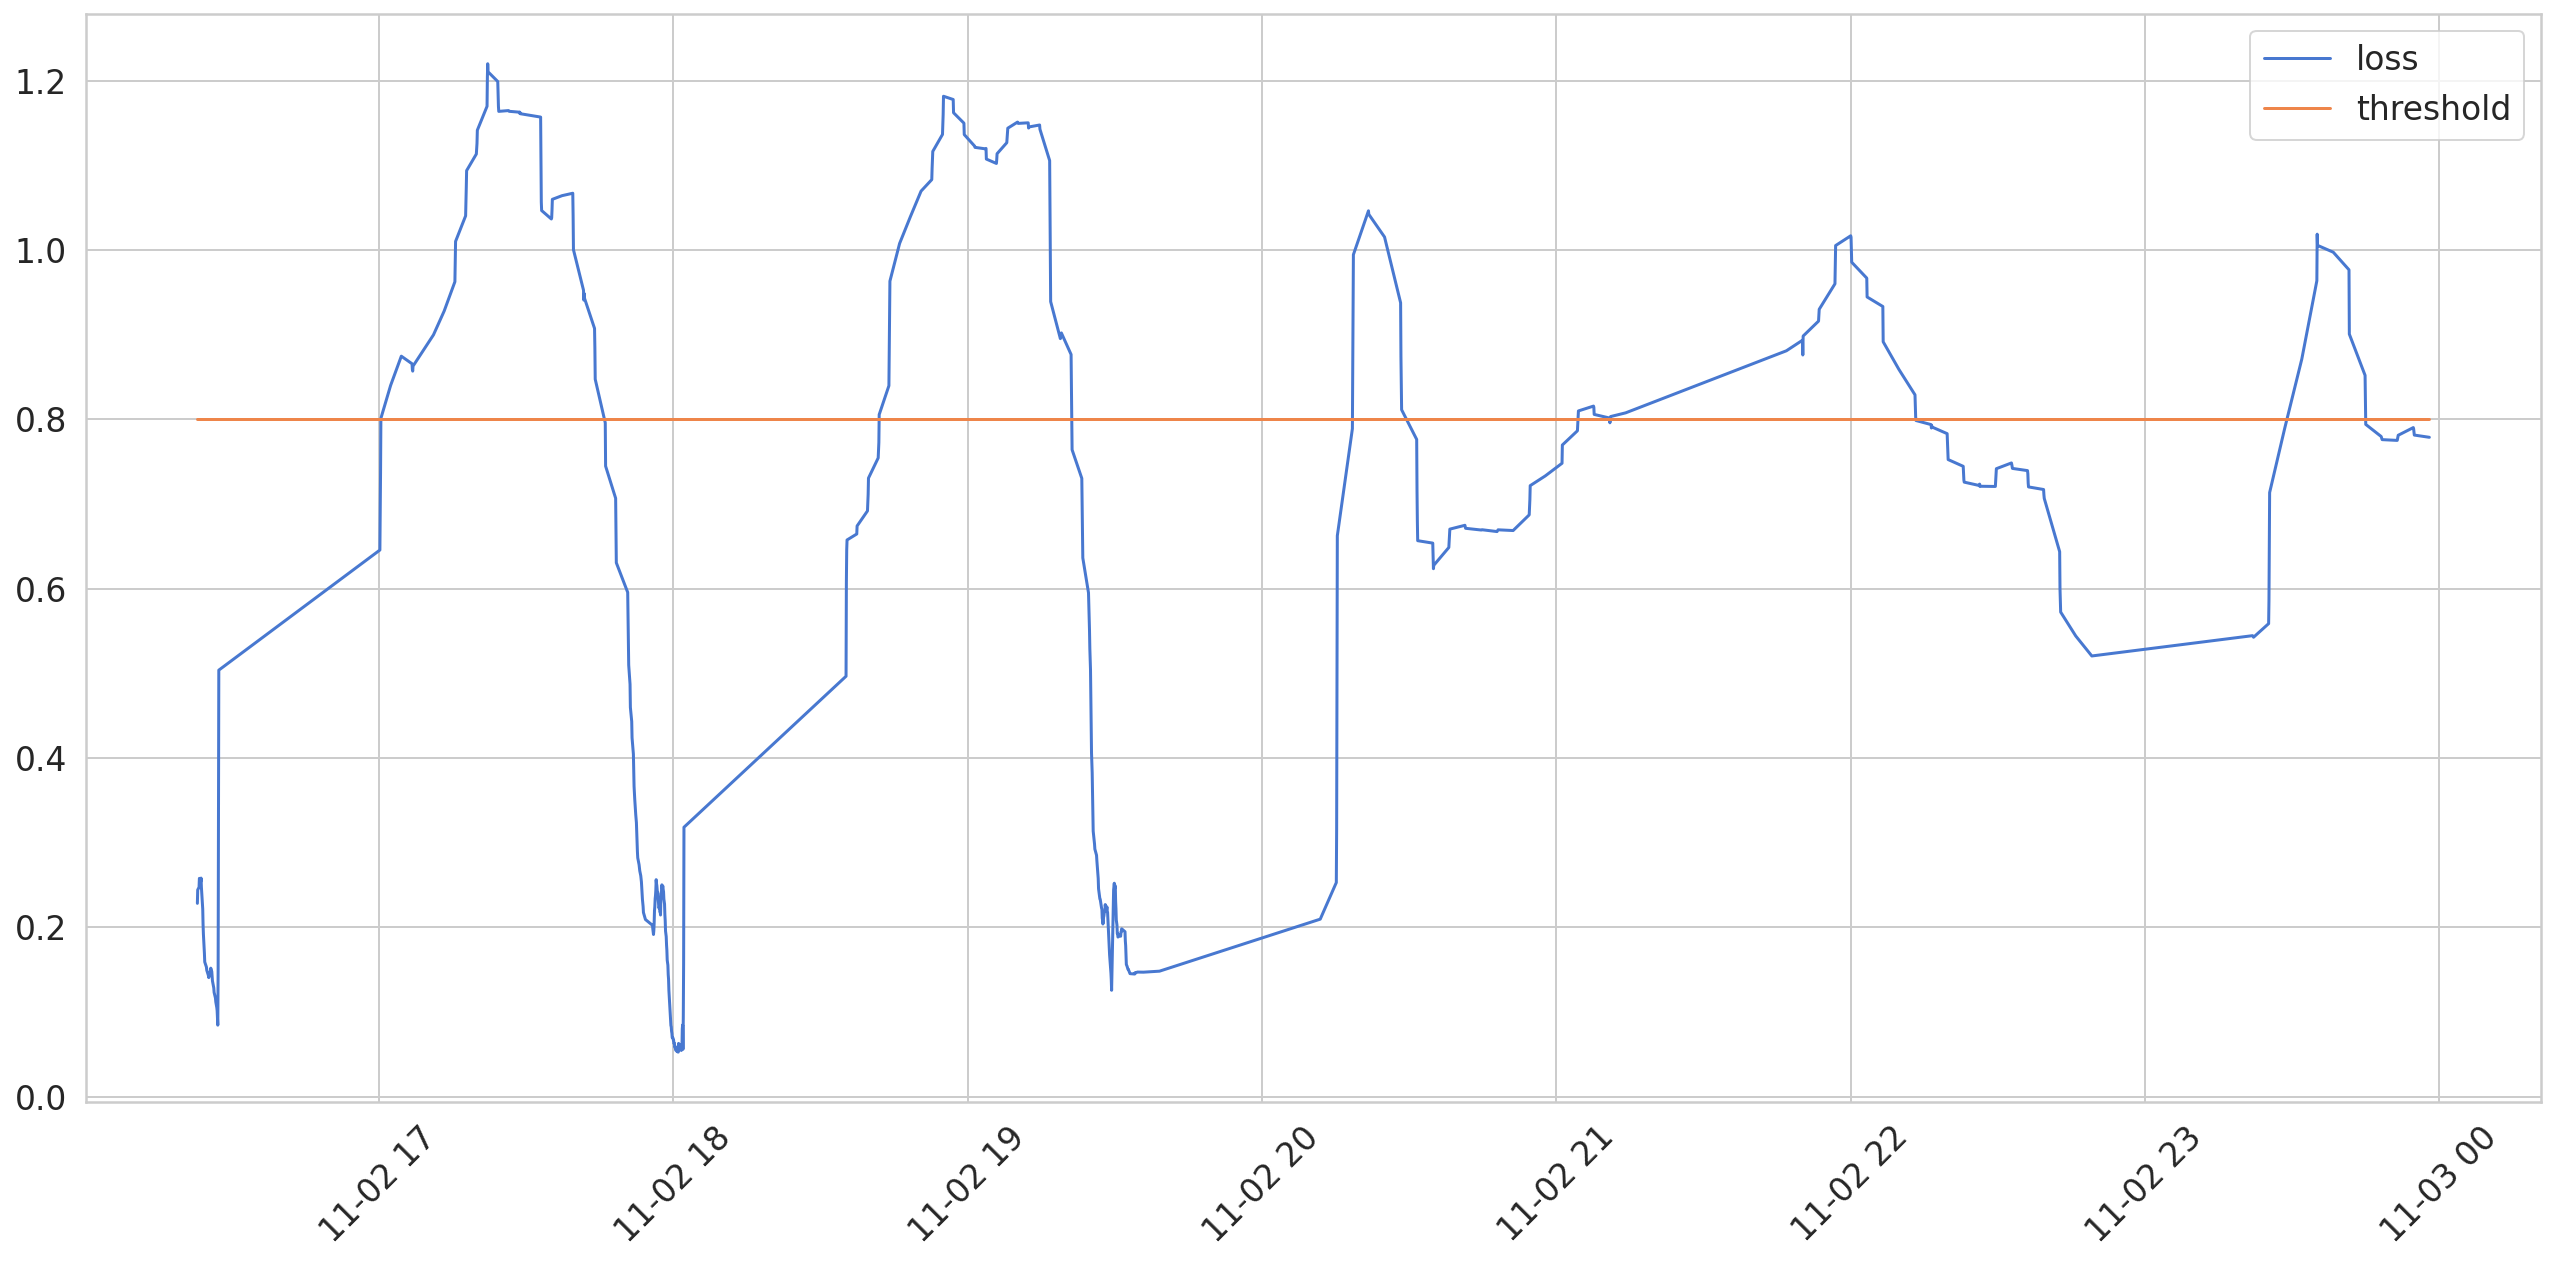

In [ ]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=45)
plt.legend()


In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies


,loss,threshold,anomaly,Solar_Current
Dates,,,,
2022-11-02 17:00:23.204,0.801211,0.8,True,-2.057621
2022-11-02 17:02:21.989,0.840020,0.8,True,1.967554
2022-11-02 17:04:33.062,0.874609,0.8,True,2.118498
2022-11-02 17:06:44.135,0.865648,0.8,True,1.917239
2022-11-02 17:06:48.231,0.858921,0.8,True,1.615351
...,...,...,...,...
2022-11-02 23:38:23.034,0.997413,0.8,True,0.659372
2022-11-02 23:41:35.548,0.976619,0.8,True,0.055596
2022-11-02 23:41:39.644,0.900652,0.8,True,0.005281


In [ ]:
anomalies.shape

(144, 4)

In [ ]:
X = np.array([test[TIME_STEPS:]['Solar Current']])

In [ ]:
X

array([[-0.59849476, -0.69912412, -0.59849476, -0.69912412, -0.59849476,
        -0.69912412, -0.64880944, -0.69912412, -0.59849476, -0.74943881,
        -0.69912412, -0.74943881, -0.69912412, -0.74943881, -0.69912412,
        -0.64880944, -0.69912412, -0.64880944, -0.69912412, -0.64880944,
        -0.69912412, -0.64880944, -0.69912412, -0.64880944, -0.69912412,
        -0.64880944, -0.69912412, -0.64880944, -0.69912412, -0.64880944,
        -0.69912412, -0.64880944, -0.69912412, -0.64880944, -0.74943881,
        -2.05762055, -2.66139673, -3.41611697, -3.51674633, -3.56706102,
        -3.51674633, -3.26517292, -2.05762055,  1.96755404,  2.11849809,
         1.91723936,  1.61535126,  1.71598063,  1.76629531,  1.61535126,
         1.5147219 ,  1.56503658,  1.01157508,  0.96126039,  1.01157508,
         0.6593723 ,  0.60905762,  0.6593723 ,  0.60905762,  0.45811357,
         0.40779889,  0.45811357,  0.05559611,  0.10591079,  0.05559611,
         0.10591079, -0.04503325,  0.00528143, -0.0

In [ ]:
y=scaler.inverse_transform(X)


In [ ]:
y=y[0]

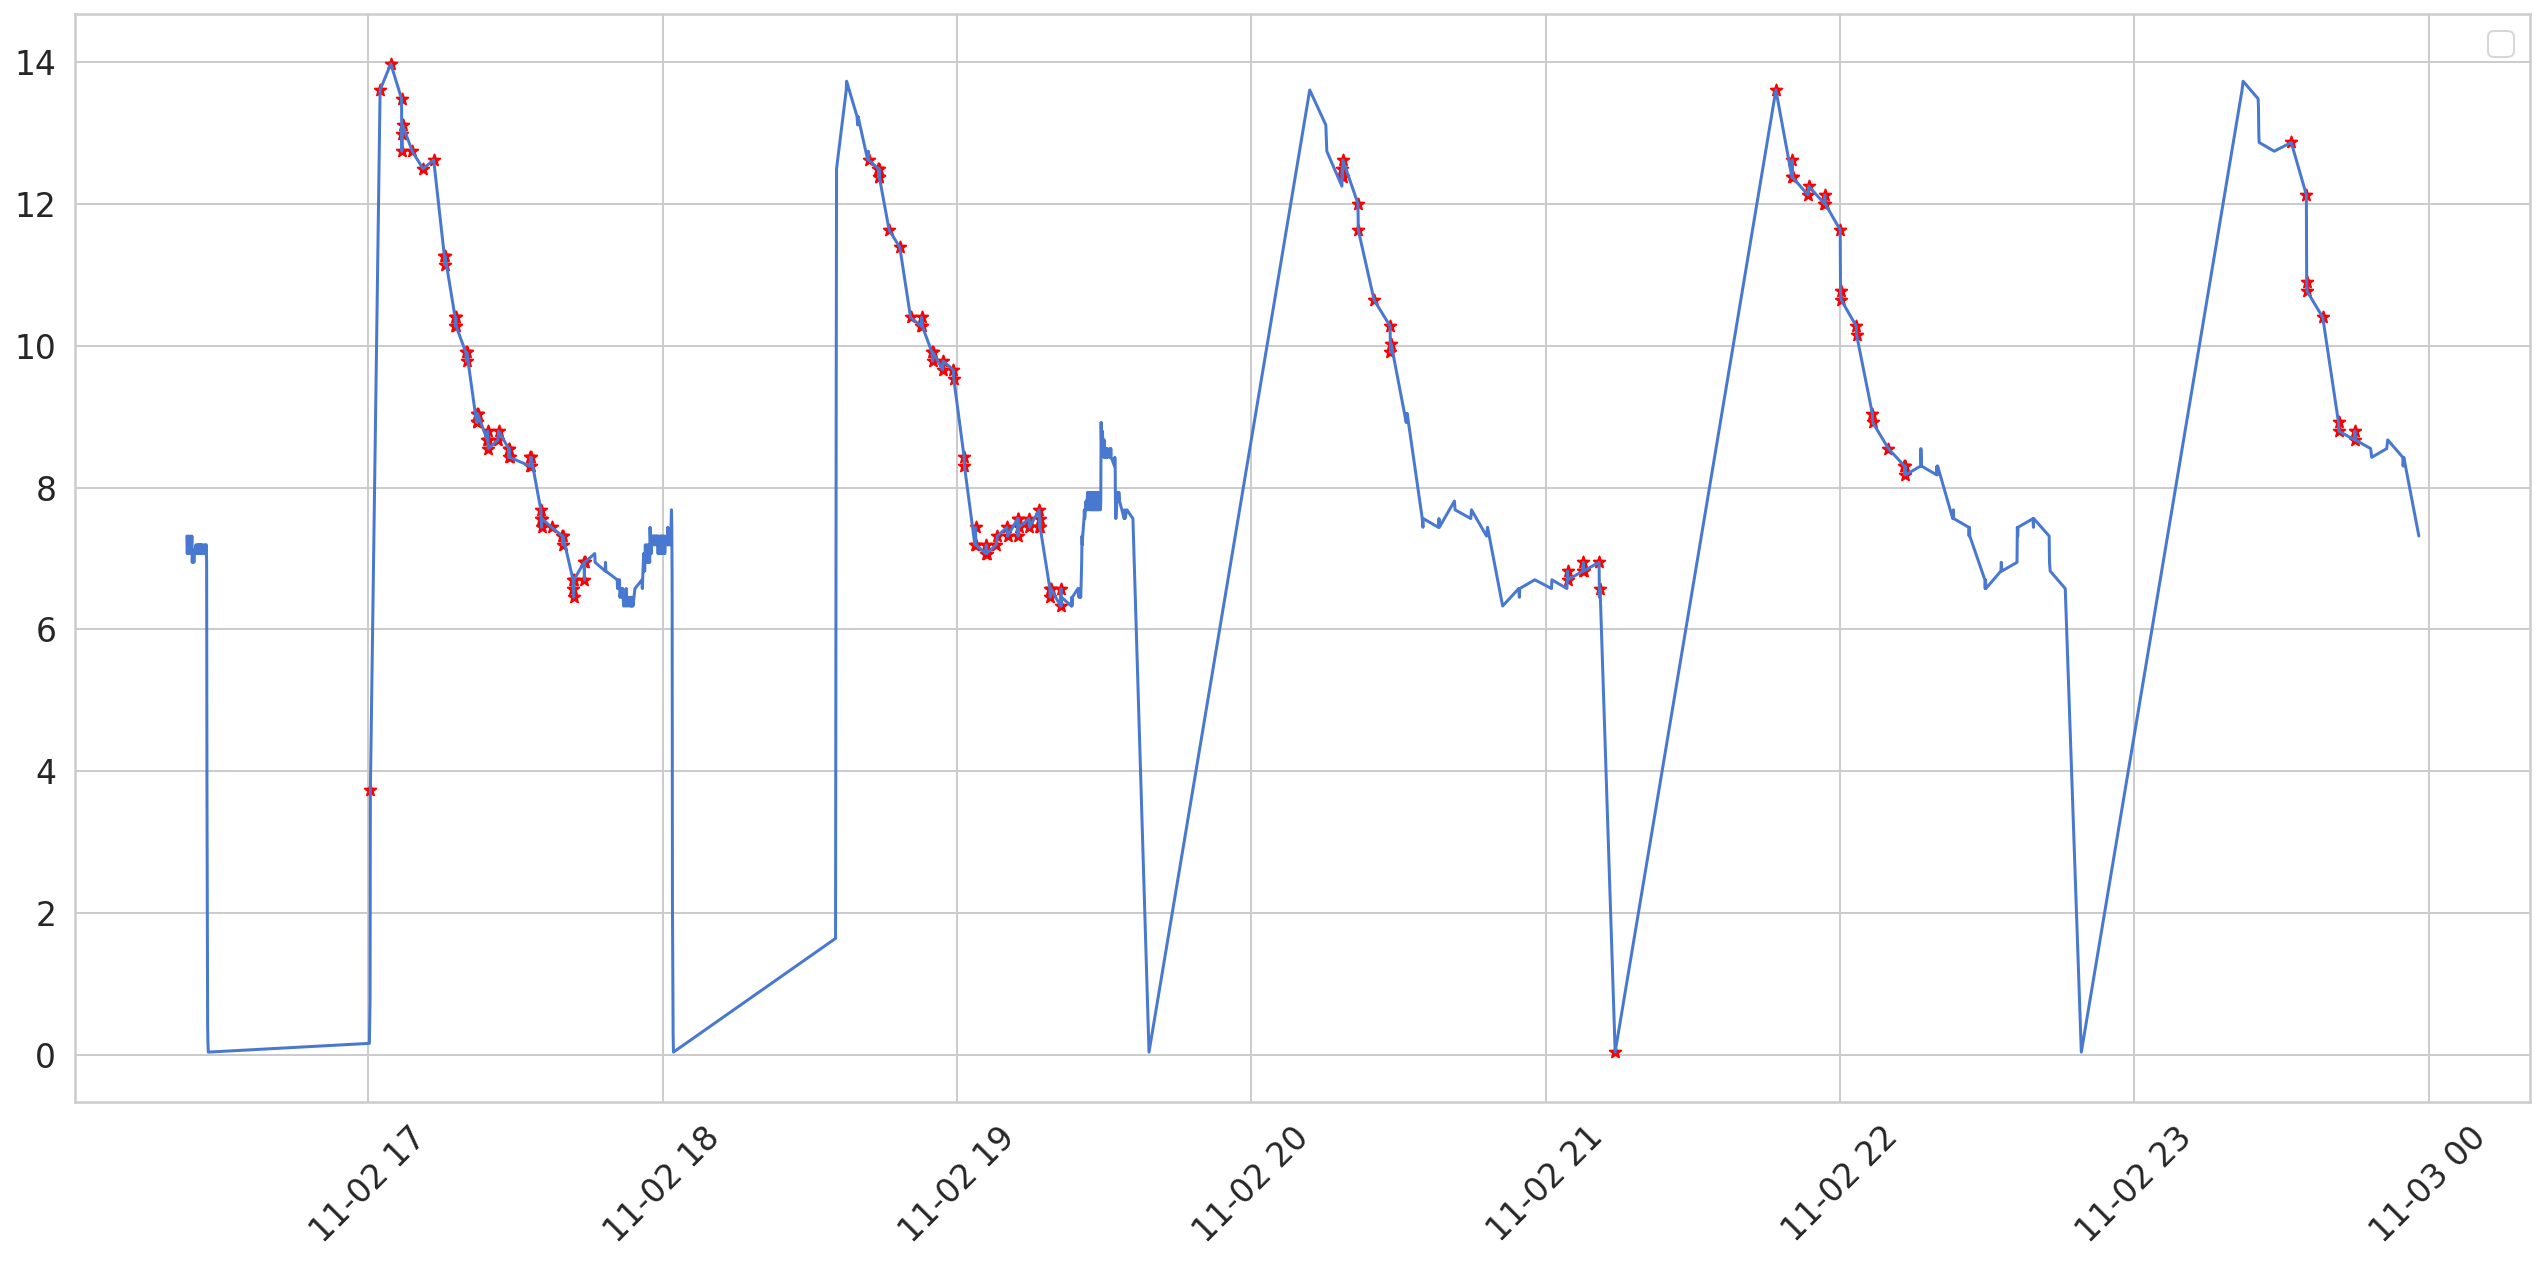

In [ ]:

plt.plot(
    test[TIME_STEPS:].index,
    y,
);
X1=np.array([anomalies.Solar_Current])

plt.scatter(
    anomalies.index,
    scaler.inverse_transform(X1), marker='*', color='red'
)

plt.xticks(rotation=45)
plt.legend()
